In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables
#print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets= diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/targets.std()


In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)

(397, 10) (45, 10) (397,) (45,)


#### Train a feedforward neural network model

In [21]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)        
    ])
    return model


In [22]:
# Print the model summary
model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=["mae"])

In [24]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [25]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5926 - mae: 0.6767


[0.6767153580983479, 0.6767153]

#### Plot the learning curves

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

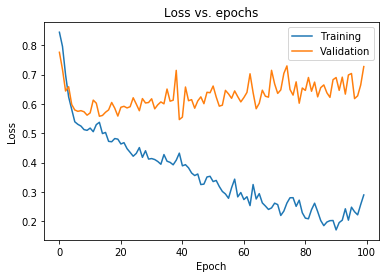

In [27]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [28]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [32]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, 
              kernel_regularizer=regularizers.l2(wd),
              activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [33]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [34]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [36]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.6761 - mae: 0.5965


[0.7183196875784132, 0.5964679]

#### Plot the learning curves

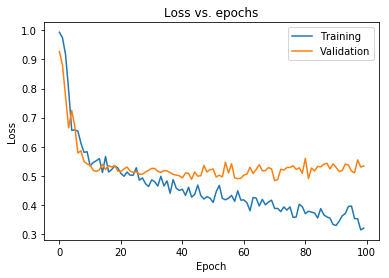

In [37]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [1]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    # TrainingCallback is child of Callback => overloading of Callback class methods
    def on_train_begin(self, logs=None):
        print('on_train_begin')
    def on_epoch_begin(self, epoch, logs=None):
        print('on_epoch_begin', epoch)
    def on_train_batch_begin(self, batch, logs=None):
        print('on_train_batch_begin', batch)
    def on_train_batch_end(self, batch, logs=None):
        print('on_train_batch_end', batch)
    def on_epoch_end(self, batch, logs=None):
        print('on_epoch_end', batch)
    def on_train_end(self, logs=None):
        print('on_train_end')
        

In [43]:
class TestingCallback(Callback):
    # testingCallback is child of Callback
    def on_test_begin(self, logs=None):
        print('on_test_begin')
    def on_test_batch_begin(self, batch, logs=None):
        print('on_test_batch_begin', batch)
    def on_test_batch_end(self, batch, logs=None):
        print('on_test_batch_end', batch)
    def on_test_end(self, logs=None):
        print('on_test_end')


In [46]:
class PredictingCallback(Callback):
    # predictingCallback is child of Callback
    def on_predict_begin(self, logs=None):
        print('on_predict_begin')
    def on_predict_batch_begin(self, batch, logs=None):
        print('on_predict_batch_begin', batch)
    def on_predict_batch_end(self, batch, logs=None):
        print('on_predict_batch_end', batch)
    def on_predict_end(self, logs=None):
        print('on_predict_end')


In [39]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [48]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [42]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

on_train_begin
on_epoch_begin 0
on_train_batch_begin 0
on_train_batch_end 0
on_train_batch_begin 1
on_train_batch_end 1
on_train_batch_begin 2
on_train_batch_end 2
on_train_batch_begin 3
on_train_batch_end 3
on_epoch_end 0
on_epoch_begin 1
on_train_batch_begin 0
on_train_batch_end 0
on_train_batch_begin 1
on_train_batch_end 1
on_train_batch_begin 2
on_train_batch_end 2
on_train_batch_begin 3
on_train_batch_end 3
on_epoch_end 1
on_epoch_begin 2
on_train_batch_begin 0
on_train_batch_end 0
on_train_batch_begin 1
on_train_batch_end 1
on_train_batch_begin 2
on_train_batch_end 2
on_train_batch_begin 3
on_train_batch_end 3
on_epoch_end 2
on_train_end


In [45]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False,
               callbacks=[TestingCallback()])

on_test_begin
on_test_batch_begin 0
on_test_batch_end 0
on_test_batch_begin 1
on_test_batch_end 1
on_test_end


0.8422336591614618

In [47]:
# Make predictions with the model
model.predict(test_data, verbose=False,
               callbacks=[PredictingCallback()])


on_predict_begin
on_predict_batch_begin 0
on_predict_batch_end 0
on_predict_batch_begin 1
on_predict_batch_end 1
on_predict_end


array([[ 0.23866373],
       [-0.48675624],
       [ 0.298056  ],
       [-0.31085297],
       [ 0.32445592],
       [ 0.28120595],
       [ 0.37150672],
       [ 0.12845929],
       [-0.13302958],
       [-0.09961228],
       [-0.42588812],
       [ 0.35947913],
       [-0.39291254],
       [ 0.4656039 ],
       [ 0.28699607],
       [ 0.38630322],
       [ 0.39438576],
       [-0.22830345],
       [ 0.19319671],
       [ 0.30810288],
       [-0.4594048 ],
       [ 0.30816883],
       [ 0.26211715],
       [ 0.35900906],
       [-0.43404412],
       [-0.21460743],
       [-0.22929095],
       [-0.07114847],
       [ 0.00837997],
       [ 0.2670905 ],
       [ 0.2371577 ],
       [ 0.3453266 ],
       [ 0.38209665],
       [ 0.3038451 ],
       [ 0.3873022 ],
       [-0.28275633],
       [-0.36569837],
       [-0.37841347],
       [ 0.27267966],
       [-0.25705066],
       [-0.4501119 ],
       [-0.44871283],
       [ 0.34953856],
       [ 0.33889142],
       [ 0.34464738]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [73]:
# Re-train the unregularised model

unregularized_model =  get_model()
unregularized_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularized_model.fit(train_data,
                              train_targets,
                              epochs=100,
                              validation_split=0.15,
                              batch_size=64,
                              verbose=False,
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [74]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5072


0.5780781626701355

In [71]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-8, 0.2)
regularized_model.compile(optimizer="adam", loss="mse")
reg_history = regularized_model.fit(train_data, train_targets,
                                  epochs=100,
                                  validation_split=0.15,
                                  batch_size=64,
                                  verbose=False,
                                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [72]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data, test_targets, verbose=False,
               callbacks=[TestingCallback()])


on_test_begin
on_test_batch_begin 0
on_test_batch_end 0
on_test_batch_begin 1
on_test_batch_end 1
on_test_end


0.6191584414905972

#### Plot the learning curves

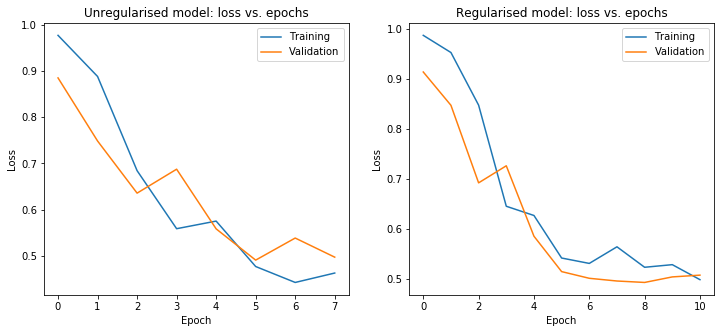

In [75]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()